# Préparez des données pour un organisme de santé publique

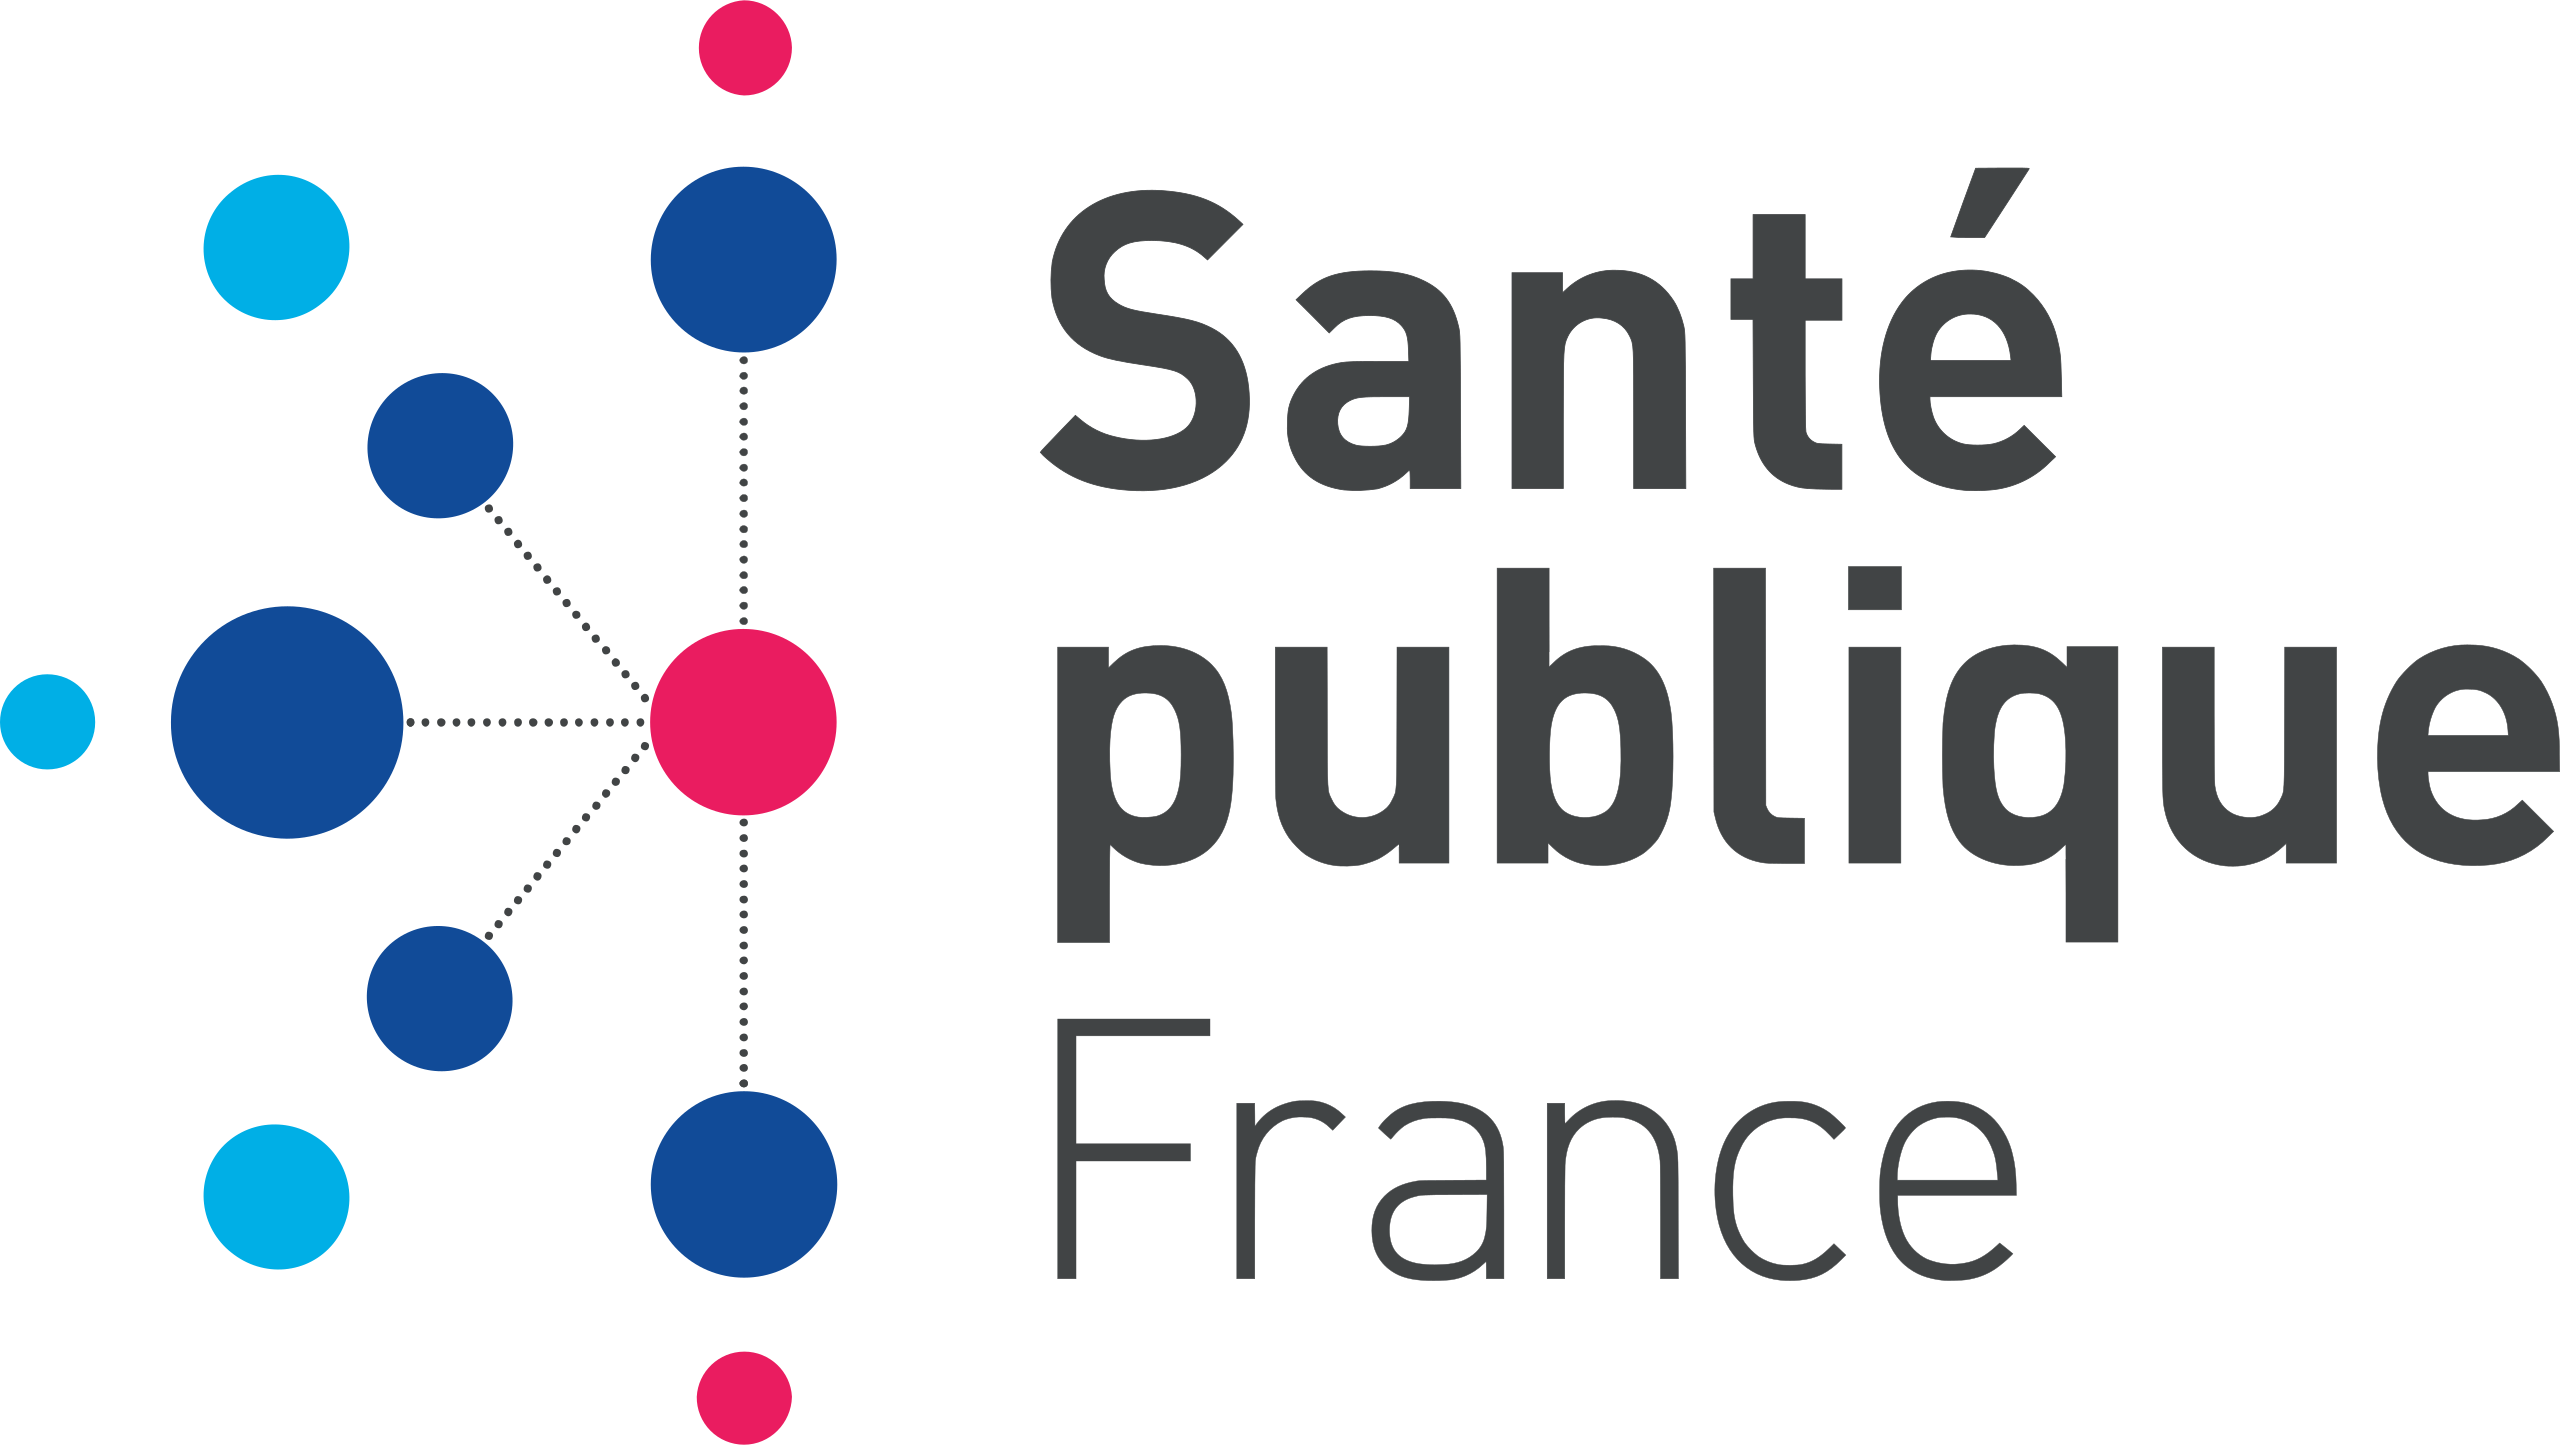



## 1. Introduction

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts qui permet de connaître la qualité nutritionnelle de leur produits.  
Ils souhaitent développer un système de suggestion ou d'auto-complétion pour remplir la base de données plus efficacement.

Mon rôle est de déterminer la faisabilité de cette application en analysant ces données et en produisants des graphiques compréhensible à tous.

**Données d'entrée**:
- [Tous les produits](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip)
- [Description de toutes les colonnes](https://world.openfoodfacts.org/data/data-fields.txt)

**Données de sortie**: 
- Rapport d'exploration
- Conclusion sur la faisabilité de l'application.

<!---
Critères d'évaluation:
- Vous avez défini les objectifs de son nettoyage de données en fonction de la problématique métier
- Vous avez défini sa démarche de préparation et nettoyage des données
-->

---
En regardant la description des colonnes, je remarque que le fichier ne contient aucune donnée qui entrerait en conflit avec les 5 principes du RGPD (Règlement Général sur la Protection des Données):
- **Le principe de finalité** : le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime ;
- **Le principe de proportionnalité et de pertinence** : les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier ;
- **Le principe d'une durée de conservation limitée** : il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier ;
- **Le principe de sécurité et de confidentialité** : le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations ;
- **Les droits des personnes**.

Tout en continuant de regarder la description, je remarque que je peux tenter de déterminer la faisabilité de suggérer les valeurs pour 3 types:
- La catégorie du produit
- Le nutri-score du produit
- Les valeur nutritionnelles d'un produit

### 1.1 Importation des données

Afin de lire, nettoyer, analyser et visualiser les données, j'utilise les librairies suivantes:
- Pandas, 
- NumPy,
- Seaborn,
- Scikit-learn,
- Matplotlib.

In [1]:
import os.path 
import pandas as pd
import numpy as np
import math  

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer  
from sklearn.model_selection import GridSearchCV  
  
import seaborn as sns
import matplotlib.pyplot as plt

import warnings  
warnings.filterwarnings('ignore')

# Allow pandas to display all columns when displaying a table
pd.set_option("display.max_columns", None)

product_csv_path = '../input/fr.openfoodfacts.org.products.csv'
products = pd.read_csv(product_csv_path, sep='\t', low_memory=False)
products.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

J'observe les nombre de lignes et colonnes

In [2]:
products.shape

(320772, 162)

## 2. Nettoyage

### 2.1 Analyse des valeurs manquantes

Je commence par observer mon jeu de donnée et les valeurs manquantes

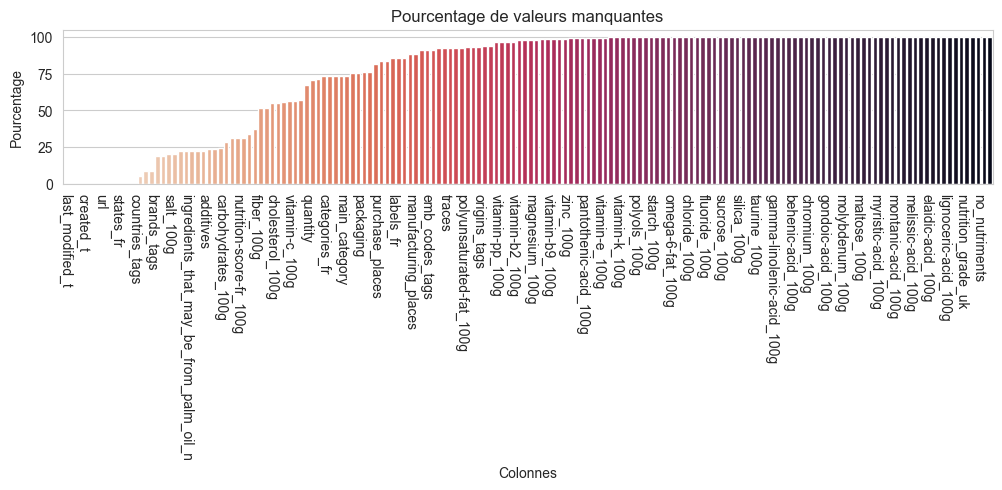

In [3]:
def create_percentage_missing_chart(df, xticksRange):
    # Get the missing data in percentage
    missing_data = df.isna().mean() * 100

    # Sort by value asc
    missing_data = missing_data.sort_values()

    # Create the figure
    plt.figure(figsize=(12, 2))

    ## Add horizontal lines
    sns.set_style('whitegrid')

    ## Set a color palette (https://seaborn.pydata.org/tutorial/color_palettes.html)
    colors = sns.color_palette("rocket_r", len(missing_data))

    ## Create the barplot
    sns.barplot(x=missing_data.index, y=missing_data,  palette=colors) # Create the bar plot

    ## Rotate the x labels and only one out of three for better readability
    plt.xticks(rotation=-90)
    plt.xticks(range(0, len(missing_data.index), xticksRange))

    ## Set the labels
    plt.ylabel('Pourcentage')
    plt.xlabel('Colonnes')
    plt.title('Pourcentage de valeurs manquantes')
    plt.show()

def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  

    # Add labels and legend to the plot  
    plt.xlabel("Valeurs manquantes en %")  
    plt.ylabel("Colonnes")  
    plt.title("Pourcentage de valeurs manquantes")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Missing: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()
    
create_percentage_missing_chart(products, 3)

Graphiquement, on remarque qu'il y a un bon nombre de colonnes avec beaucoup de valeurs manquantes.  
Le but de l'application étant de suggérer les valeurs pour un produit, je décide de prendre en compte toutes les colonnes qui ont moins de 90% de valeurs manquantes.

Avant cela, je fais une bref observation en chiffres

In [4]:
missing_values = products.isna().mean() * 100
columns_below_or_equal_90_percent = missing_values[missing_values <= 90]
columns_between_50_and_90_percent = missing_values[(missing_values >= 50) & (missing_values <= 90)]
columns_below_50_percent = missing_values[missing_values < 50]

columns_above_90_percent = missing_values[missing_values > 90]  

print(f"Sur {len(products.columns)} colonnes, il y a:\n")
print(f"- {len(columns_below_or_equal_90_percent)} colonnes qui ont moins de 90% de valeurs manquantes")
print(f"---- {len(columns_between_50_and_90_percent)} colonnes ont plus de 50% de valeurs manquantes")
print(f"---- {len(columns_below_50_percent)} colonnes ont moins de 50% de valeurs manquantes")
      
print(f"\n- {len(columns_above_90_percent)} colonnes on plus de 90% de valeurs manquantes")

Sur 162 colonnes, il y a:

- 62 colonnes qui ont moins de 90% de valeurs manquantes
---- 28 colonnes ont plus de 50% de valeurs manquantes
---- 34 colonnes ont moins de 50% de valeurs manquantes

- 100 colonnes on plus de 90% de valeurs manquantes


Je vais donc conserver ici 62 colonnes uniquement

In [5]:
products_below_90_percent = products[columns_below_or_equal_90_percent.index] 
products_below_90_percent.shape

(320772, 62)

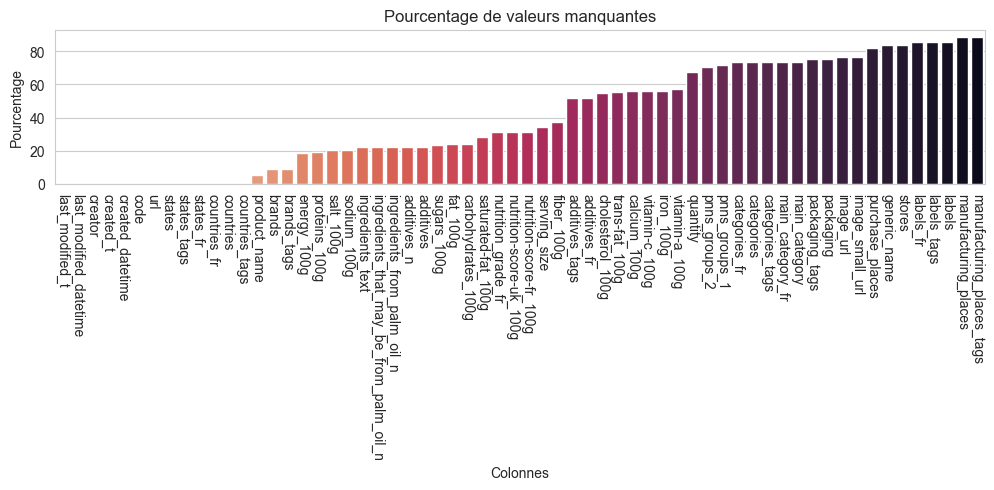

In [6]:
create_percentage_missing_chart(products_below_90_percent, 1)

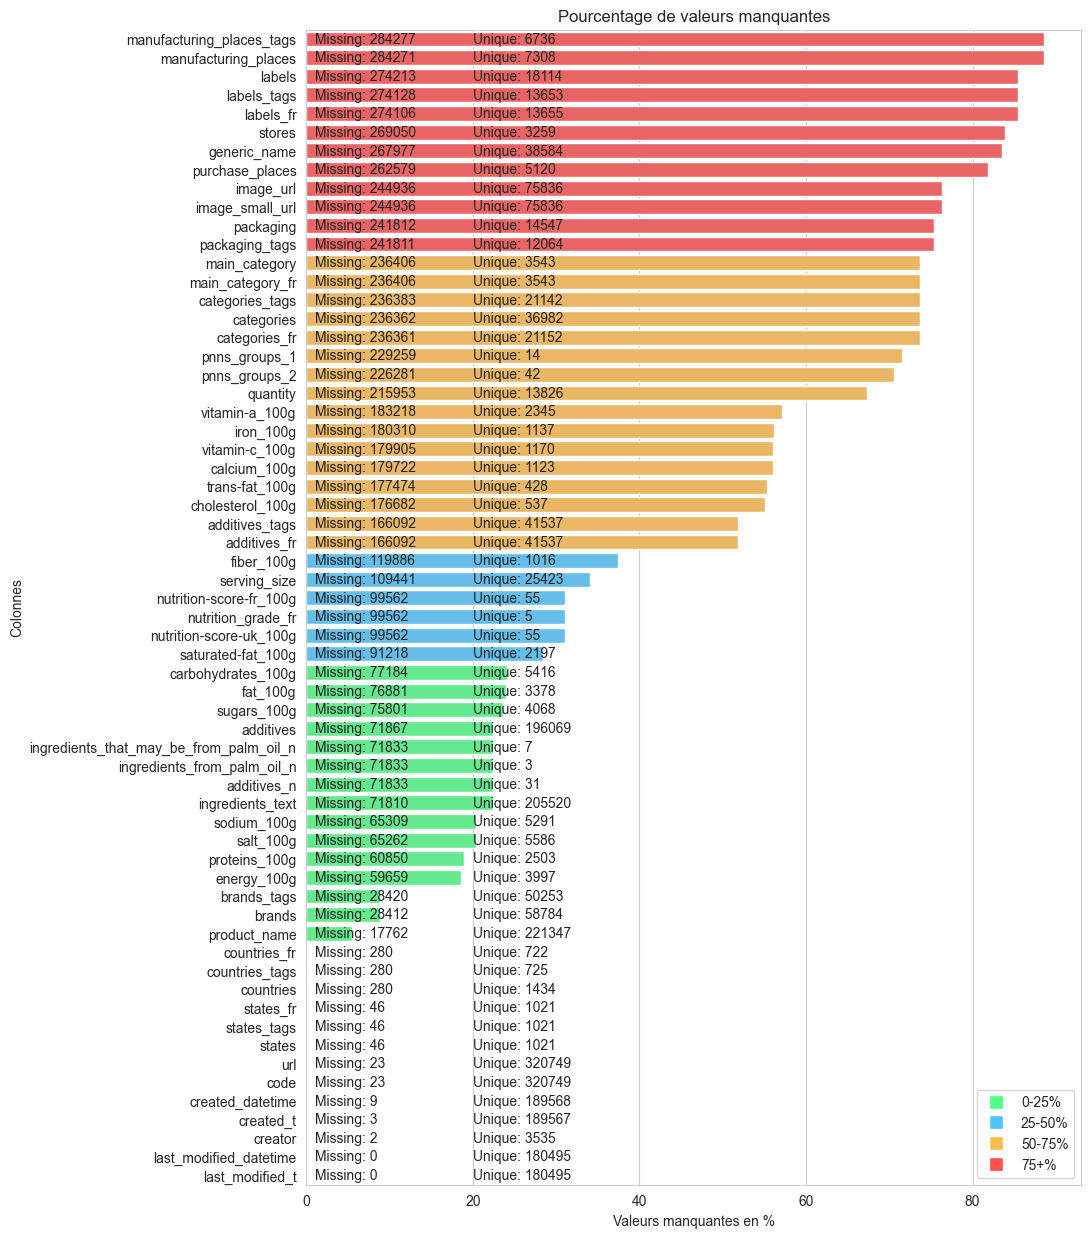

In [7]:
display_graph_missing_data(products_below_90_percent, 15)

Je fais un pré-tri des colonnes que je trouve inutiles de conserver pour l'application.  
Principalement des colonnes qualitatives qui ont beaucoup de valeurs uniques et manquantes ou qui n'ont pas d'intérêt (ex: created_t)

In [8]:
delete_useless_columns = [    
    "manufacturing_places_tags",
    "manufacturing_places",
    "labels",
    "labels_tags",
    "labels_fr",
    "stores",
    "generic_name",
    "purchase_places",
    "image_url",
    "image_small_url",
    "packaging",
    "packaging_tags",
    "main_category",
    "categories_tags",
    "categories",
    "categories_fr",
    "pnns_groups_1",
    "pnns_groups_2",
    "quantity",
    "additives_tags",
    "additives_fr",
    "additives",
    "serving_size",
    "ingredients_text",
    "brands_tags",
    "brands",
    "countries",
    "countries_tags",
    "states_fr",
    "states",
    "states_tags",
    "url",
    "created_datetime",
    "created_t",
    "creator",
    "last_modified_datetime",
    "last_modified_t",
    "ingredients_that_may_be_from_palm_oil_n",
    "nutrition-score-uk_100g",
]

products_pre_clean = products_below_90_percent.drop(columns=delete_useless_columns)  

In [9]:
products_pre_clean.shape

(320772, 23)

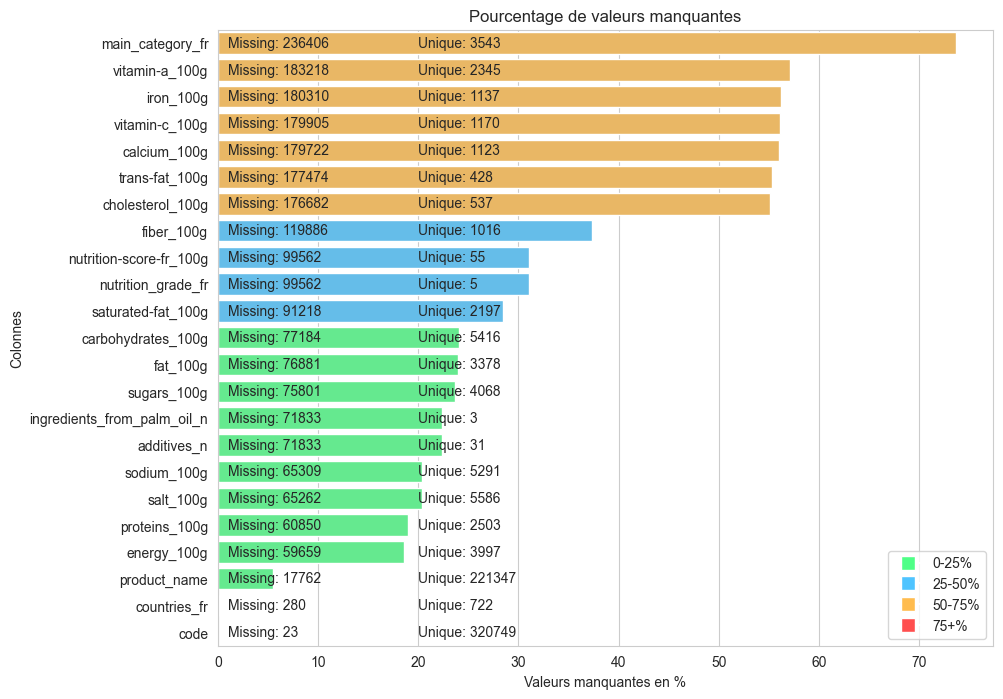

In [10]:
display_graph_missing_data(products_pre_clean, 8)

Il me reste donc 23 colonnes à nettoyer & analyser.  
Observons le type de ces colonnes:

In [11]:
pd.set_option('display.max_rows', None)  
# Create a DataFrame containing the data types  
data_types_table = pd.DataFrame(products_pre_clean.dtypes, columns=['Data Type'])  
# Display the table  
data_types_table

,Data Type
code,object
product_name,object
countries_fr,object
additives_n,float64
ingredients_from_palm_oil_n,float64
nutrition_grade_fr,object
main_category_fr,object
energy_100g,float64
fat_100g,float64
saturated-fat_100g,float64


Les types des colonnes me paraît correct.

### 2.1 Suppression des doublons

Je vérifie si il y a des doublons sur la colonne "code" uniquement et je les supprimes.
Également pour tous les produits qui n'ont pas de code et qui ne sont pas identifiables.

In [12]:
pd.set_option('display.max_rows', 5)  

print(f"Suppression de {products_pre_clean['code'].duplicated().sum()} doublons")
products_pre_clean.drop_duplicates(subset='code', keep='first', inplace=True)

print(f'Suppression de {len(products_pre_clean[products_pre_clean["code"].isna()])} produits sans code')
products_pre_clean = products_pre_clean[~products_pre_clean["code"].isna()]

Suppression de 22 doublons
Suppression de 1 produits sans code


### 2.2 Analyses des valeurs qualitatives

Je vais maintenant faire une première approche de mes colonnes qualitatives.

#### 2.2.1 product_name

In [13]:
print(f"Il y a {products_pre_clean['product_name'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nom de produits")
print(f"Il y a {len(products_pre_clean['product_name'].unique())} valeurs unique")

Il y a 17762/320749 valeurs sans nom de produits
Il y a 221344 valeurs unique


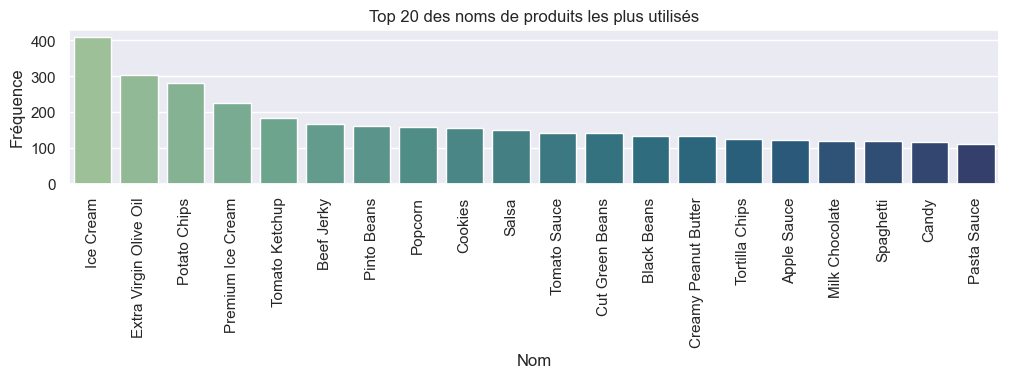

In [14]:
top_20_products = products_pre_clean['product_name'].value_counts().head(20)  
  
# Create a bar plot using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(12, 2))  
sns.barplot(x=top_20_products.index, y=top_20_products.values, palette="crest")  
plt.xticks(rotation=90)  
plt.xlabel('Nom')  
plt.ylabel('Fréquence')  
plt.title('Top 20 des noms de produits les plus utilisés')  
plt.show()  

Je vois qu'il y a quelques produits qui ont des noms similaires sans grand écart.  
Je vais remplacer toutes les valeurs manquantes par "inconnu"

In [15]:
products_pre_clean["product_name"] = products_pre_clean["product_name"].fillna("inconnu")
print(f"Il reste {products_pre_clean['product_name'].isna().sum()} produit sans nom.")

Il reste 0 produit sans nom.


#### 2.2.3 countries_fr

In [16]:
print(f"Il y a {products_pre_clean['countries_fr'].isna().sum()}/{(len(products_pre_clean))} valeurs sans pays")
print(f"Il y a {len(products_pre_clean['countries_fr'].unique())} valeurs unique")

Il y a 280/320749 valeurs sans pays
Il y a 718 valeurs unique


Pour 280 valeurs, je préfère les supprimer car il n'affecterons pas le dataset

In [17]:
products_pre_clean.dropna(subset=['countries_fr'], inplace=True)  
print(f"Il y a {products_pre_clean['countries_fr'].isna().sum()} valeurs sans pays")

Il y a 0 valeurs sans pays


J'examine rapidement le dataset

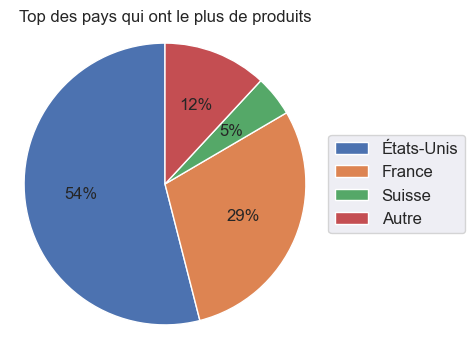

In [18]:
top_3_countries = products_pre_clean['countries_fr'].value_counts().head(3)  
  
# Calculate the sum of values of all other countries  
other_countries_count = products_pre_clean['countries_fr'].value_counts().iloc[3:].sum()  

# Add a new value for the sum of remaining countries to the top 3 countries series  
top_3_countries['Autre'] = other_countries_count  
  
# Create a pie chart  
plt.figure(figsize=(4, 4))  
patches, texts, _ = plt.pie(top_3_countries.values, startangle=90, autopct='%1.f%%')  
  
# Update the labels to include "Others"  
labels = top_3_countries.index.map(lambda x: x if x != "Others" else f"Others ({other_countries_count})")  
plt.legend(patches, labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)  
  
plt.title('Top des pays qui ont le plus de produits')  
plt.axis('equal')  
  
plt.show()

# Todo > Afficher les categories les plus utilisé (word cloud)

On remarque que les États-Unis et la France représente 83% des produits à eux deux.

#### 2.2.4 nutrition_grade_fr	

In [19]:
print(f"Il y a {products_pre_clean['nutrition_grade_fr'].isna().sum()}/{(len(products_pre_clean))} valeurs sans grade de nutrition")
print(f"Il y a {len(products_pre_clean['nutrition_grade_fr'].unique())} valeurs unique")

Il y a 99316/320469 valeurs sans grade de nutrition
Il y a 6 valeurs unique


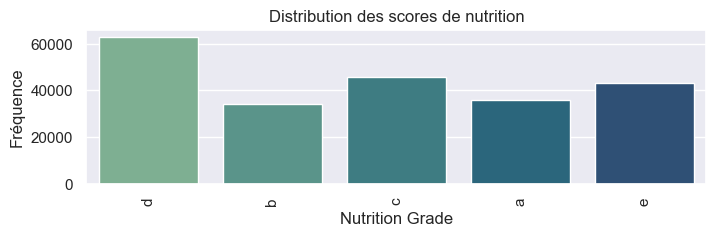

In [20]:
# Create a histogram using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(8, 2))  
sns.countplot(x=products_pre_clean['nutrition_grade_fr'], palette="crest")  
plt.xlabel('Nutrition Grade')  
plt.ylabel('Fréquence')  
plt.title('Distribution des scores de nutrition')  
plt.xticks(rotation=90)  
plt.show()

In [21]:
products_pre_clean['nutrition_grade_fr'].value_counts()

nutrition_grade_fr
d    62746
c    45528
e    43018
a    35625
b    34236
Name: count, dtype: int64

Les grades des produits sont assez similaires, le grade D et C sont en tête de classement.
Pour simplifier le remplacement des valeurs manquantes, je vais créer une nouvelle colonne nutrition_grade_n qui remplace a,b,c,d,e par 1,2,3,4,5.

In [22]:
products_pre_clean['nutrition_grade_n'] = products_pre_clean['nutrition_grade_fr'].replace({'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5})

In [23]:
products_pre_clean['nutrition_grade_n'].value_counts()

nutrition_grade_n
4.0    62746
3.0    45528
5.0    43018
1.0    35625
2.0    34236
Name: count, dtype: int64

Je m'occuperai de remplacer les valeurs manquantes plus bas dans ce notebook. Tout d'abord je continue à nettoyer et vérifier les colonnes.

#### 2.2.5 main_category_fr

In [24]:
print(f"Il y a {products_pre_clean['main_category_fr'].isna().sum()}/{(len(products_pre_clean))} valeurs sans catégories")
print(f"Il y a {len(products_pre_clean['main_category_fr'].unique())} valeurs unique")

Il y a 236207/320469 valeurs sans catégories
Il y a 3533 valeurs unique


Beaucoup de valeurs unique, ça peut être plus compliqué à prédire, je vais supprimer toutes les categories contenant ":" car même si j'ai sélectionner main_category_fr, je remarque que j'ai également des catégories encore en anglais, italien, ...

Je les remplace par NA et sauvegarde le tout dans une nouvelle colonne que je nommerai category_fr_clean si je souhaite par la suite comparer.

In [25]:
count_colon = products_pre_clean['main_category_fr'].str.contains(':').sum()  
print(f"Il y a {count_colon} catégories qui ne sont pas français")
products_pre_clean['category_fr_clean'] = products_pre_clean['main_category_fr']
products_pre_clean['category_fr_clean'] = np.where(products_pre_clean['main_category_fr'].str.contains(':'), None, products_pre_clean['main_category_fr'])  

print(f"Il y a {len(products_pre_clean['category_fr_clean'].unique())} valeurs unique")

Il y a 2896 catégories qui ne sont pas français
Il y a 1494 valeurs unique


Je regarde le top des catégories

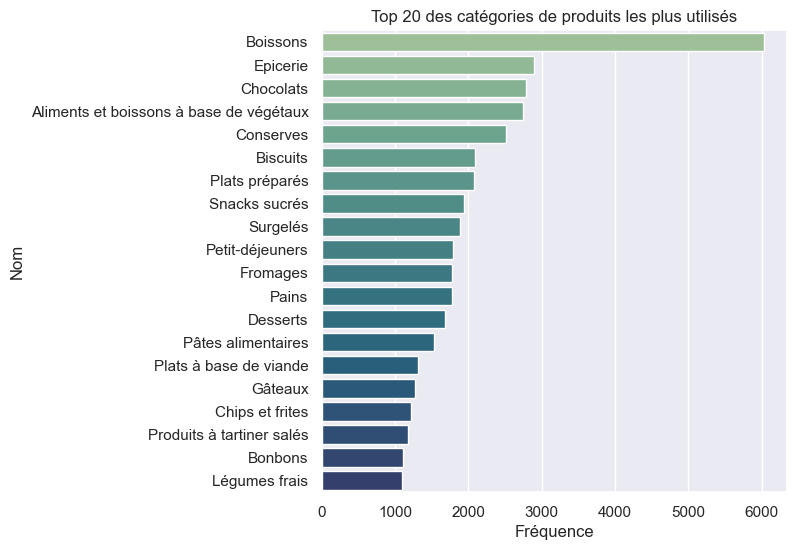

In [26]:
top_20_cat = products_pre_clean['main_category_fr'].value_counts().head(20)  
sns.set(style="darkgrid")  
plt.figure(figsize=(6, 6))  
sns.barplot(x=top_20_cat.values, y=top_20_cat.index, palette="crest")  
plt.xlabel('Fréquence')  
plt.ylabel('Nom')  
plt.title('Top 20 des catégories de produits les plus utilisés')  
plt.show()

Avec 1494 valeurs unique et quelques catégories qui sont réutilisé +1000 fois, je vais surement pouvoir suggérer des catégories par la suite.  
Mais d'abord, je fini de nettoyer le reste de mes colonnes avant de passer au remplacement de valeur manquantes pour les catégories.

### 2.3 Analyses des valeurs quantitatives

#### 2.3.1 additives_n

In [27]:
print(f"Il y a {products_pre_clean['additives_n'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nb d'additifs")
print(f"Il y a {len(products_pre_clean['additives_n'].unique())} valeurs unique")

Il y a 71616/320469 valeurs sans nb d'additifs
Il y a 32 valeurs unique


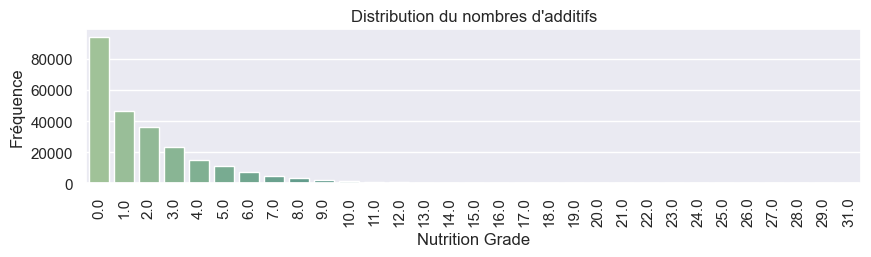

In [28]:
# Create a histogram using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(10, 2))  
sns.countplot(x=products_pre_clean['additives_n'], palette="crest")  
plt.xlabel('Nutrition Grade')  
plt.ylabel('Fréquence')  
plt.title('Distribution du nombres d\'additifs')  
plt.xticks(rotation=90)  
plt.show()

Pour le nombre d'additif, je vais remplacer les valeurs manquantes par 0.

In [29]:
products_pre_clean['additives_n'] = products_pre_clean['additives_n'].fillna(0)
print(f"Il y a {products_pre_clean['additives_n'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nb d'additifs")

Il y a 0/320469 valeurs sans nb d'additifs


#### 2.3.2 ingredients_from_palm_oil_n

In [30]:
print(f"Il y a {products_pre_clean['ingredients_from_palm_oil_n'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nutri score")
print(f"Il y a {len(products_pre_clean['ingredients_from_palm_oil_n'].unique())} valeurs unique")

Il y a 71616/320469 valeurs sans nutri score
Il y a 4 valeurs unique


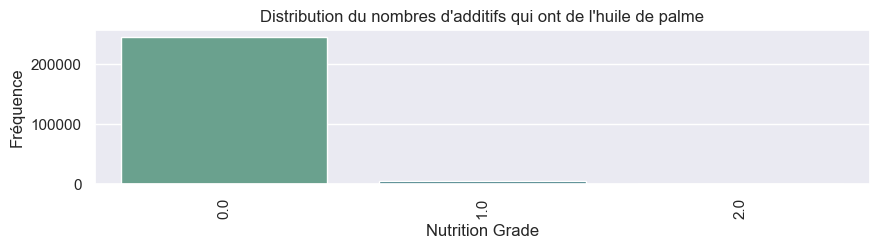

In [31]:
# Create a histogram using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(10, 2))  
sns.countplot(x=products_pre_clean['ingredients_from_palm_oil_n'], palette="crest")  
plt.xlabel('Nutrition Grade')  
plt.ylabel('Fréquence')  
plt.title('Distribution du nombres d\'additifs qui ont de l\'huile de palme')  
plt.xticks(rotation=90)  
plt.show()

La plupart sont à 0, j'ai pas vraiment besoin de cette colonne. Je la supprime complètement.

In [32]:
products_pre_clean = products_pre_clean.drop(columns=["ingredients_from_palm_oil_n"])
products_pre_clean.shape

(320469, 24)

#### 2.3.3 nutrition-score-fr_100g

In [33]:
print(f"Il y a {products_pre_clean['nutrition-score-fr_100g'].isna().sum()}/{(len(products_pre_clean))} valeurs sans nutri score")
print(f"Il y a {len(products_pre_clean['nutrition-score-fr_100g'].unique())} valeurs unique")

Il y a 99316/320469 valeurs sans nutri score
Il y a 56 valeurs unique


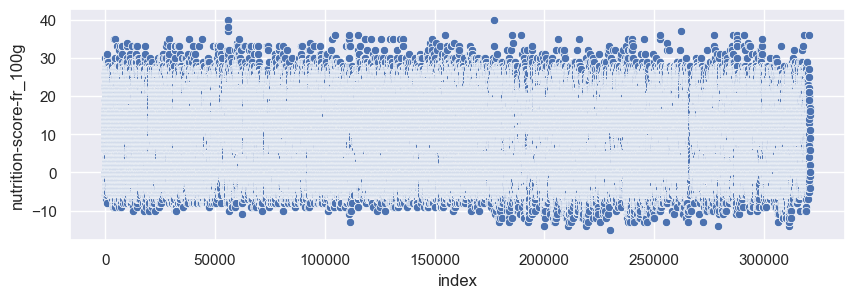

In [34]:
# Reset index for the dataframe
prds = products_pre_clean.copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='nutrition-score-fr_100g')

# Show the plot  
plt.show()

[Wikipedia](https://fr.wikipedia.org/wiki/Nutri-score#:~:text=Le%20Nutri%2Dscore%20est%20un,nutritionnelle%20d'un%20produit%20alimentaire.) indique que le score varie entre -15 et +40.

- A = -15 jusqu'a -2
- B = -1 à +3
- C = +4 à +11
- D = +12 à +16
- E = +17 à +40

Je vérifie les outliers même si le graphique à l'air de ne pas en avoir

In [35]:
above_40 = products_pre_clean['nutrition-score-fr_100g'] > 40
below_minus_15 = products_pre_clean['nutrition-score-fr_100g'] < -15
len(products_pre_clean[above_40 | below_minus_15])

0

Est-ce que j'ai des nutri-grade qui n'ont pas de nutri-score et vice-versa ?

In [36]:
  # Count the number of rows with missing values  
missing_value_grade = products_pre_clean['nutrition_grade_fr'].isnull().sum()
missing_value_score = products_pre_clean['nutrition-score-fr_100g'].isnull().sum()

missing_value_both = len(products_pre_clean[(products_pre_clean['nutrition_grade_fr'].isnull()) | (products_pre_clean['nutrition-score-fr_100g'].isnull())])

print(f"Nutrition grade a {missing_value_grade} valeurs manquantes")
print(f"Nutrition score a {missing_value_score} valeurs manquantes")
print(f"Nutrition score et grade manquantes réunis = {missing_value_both}")

missing_value_rows = products_pre_clean[products_pre_clean['nutrition_grade_fr'].isnull() != products_pre_clean['nutrition-score-fr_100g'].isnull()]  
  
missing_value_rows_count = len(missing_value_rows)  
print(f"\nIls ont {missing_value_rows_count} différence de ligne (dans le cas où on a le même nombre de valeurs manquantes sur des lignes différentes)")

Nutrition grade a 99316 valeurs manquantes
Nutrition score a 99316 valeurs manquantes
Nutrition score et grade manquantes réunis = 99316

Ils ont 0 différence de ligne (dans le cas où on a le même nombre de valeurs manquantes sur des lignes différentes)


Je vais vérifier si j'ai une cohérence entre le nutri-grade et le nutri score avec les conditions de wikipedia.

In [37]:
# Filter the dataframe based on the conditions  
grade_a = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= -15) & (products_pre_clean['nutrition-score-fr_100g'] <= -2)]
grade_b = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= -1) & (products_pre_clean['nutrition-score-fr_100g'] <= 3)]  
grade_c = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= 4) & (products_pre_clean['nutrition-score-fr_100g'] <= 11)]  
grade_d = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= 12) & (products_pre_clean['nutrition-score-fr_100g'] <= 16)]  
grade_e = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= 17) & (products_pre_clean['nutrition-score-fr_100g'] <= 40)]  

# Count the correct and incorrect values
grade_lvls = ['a', 'b', 'c', 'd', 'e']
grade_numbers = [grade_a, grade_b, grade_c, grade_d, grade_e]
for grade_lvl, grade_number in zip(grade_lvls, grade_numbers):
    actual_grade_nb = products_pre_clean['nutrition_grade_fr'].isin([grade_lvl]).sum()
    correct_grade_nb = len(grade_number)
    print(f"Grade {grade_lvl} à {actual_grade_nb} valeurs et devrait en avoir {correct_grade_nb}")

# test = products_pre_clean.loc[(products_pre_clean['nutrition-score-fr_100g'] >= -15) & (products_pre_clean['nutrition-score-fr_100g'] >= -2) & (products_pre_clean['nutrition_grade_fr'] == "a")]
# len(test)
# pd.set_option('display.max_colwidth', None)  

# print(products[products["code"] == "0000000018524"].url)
# print(products[products["code"] == "0000000031172"].url)
# print(products[products["code"] == "0000000038348"].url)
# print(products[products["code"] == "0000000069601"].url)
# print(products[products["code"] == "0000236555909"].url)

Grade a à 35625 valeurs et devrait en avoir 26895
Grade b à 34236 valeurs et devrait en avoir 51282
Grade c à 45528 valeurs et devrait en avoir 46952
Grade d à 62746 valeurs et devrait en avoir 42942
Grade e à 43018 valeurs et devrait en avoir 53082


En regardant les urls des nutri score de A en trop, je remarque que la donnée que j'ai sur le site et via le dataset diffères.
J'ai des produits qui sont indiqués en B ou D sur le site et en A dans le dataset fourni.

On pourrait très bien corrigé tous les nutri-score en utilisant les conditions mais je ne suis pas un expert du domaine et je ne suis pas sur. Le nutri score est différent comparé au donnée reel vs dataset, je préfère ne pas remplacer les nutri-score actuels, je modifierai trop de données et risque de rendre inutilisable ce dataset.

Néamoins je vais pouvoir tenter de les suggérer plus bas dans ce notebook.

Pour récapituler, en valeurs manquantes, il me reste:

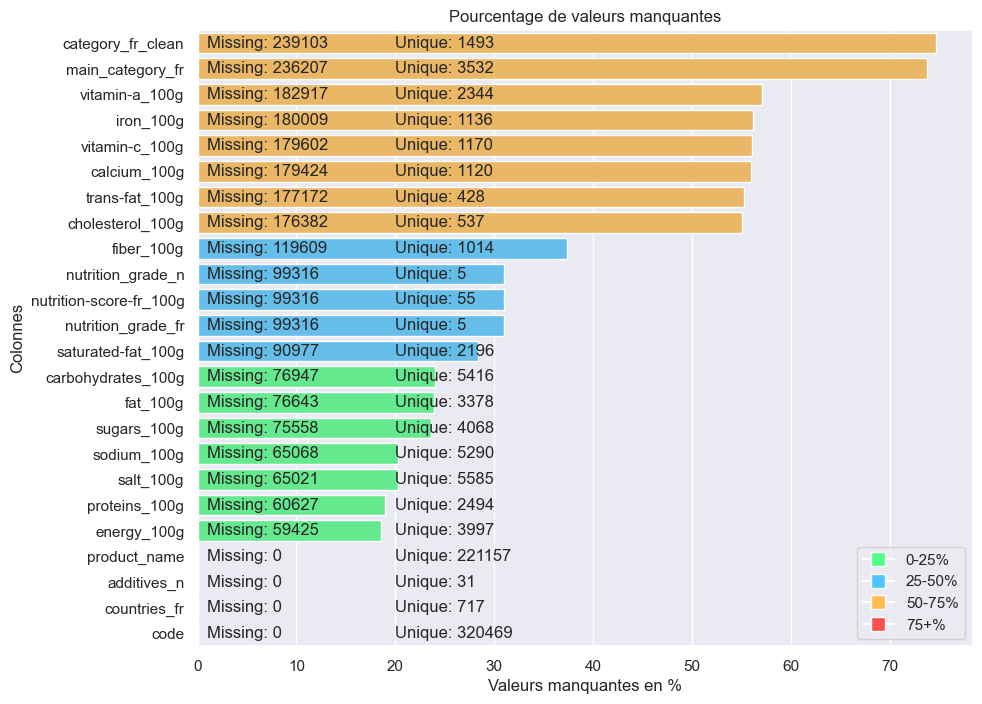

In [38]:
display_graph_missing_data(products_pre_clean, 8)

#### 2.3.4 *_100g

Maintenant je vais analyser les colonnes qui finissent toutes par _100g (sauf le nutri score)

In [39]:
products_pre_clean_100g = products_pre_clean.filter(like='_100g')
products_pre_clean_100g.drop(columns=["nutrition-score-fr_100g"], inplace=True)

products_pre_clean_100g_columns = products_pre_clean_100g.columns

products_pre_clean_100g.shape

(320469, 15)

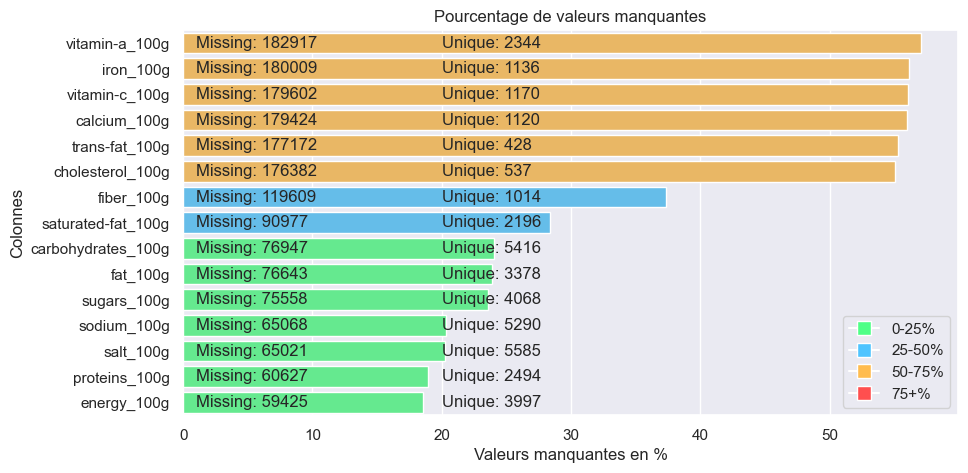

In [40]:
display_graph_missing_data(products_pre_clean_100g, 5)

In [41]:
pd.set_option('display.max_rows', None)
products_pre_clean_100g.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,2.610440e+05,243826.000000,229492.000000,143297.000000,144087.000000,243522.000000,244911.000000,200860.000000,259842.000000,255448.000000,255401.000000,137552.000000,140867.000000,141045.000000,140460.000000
mean,1.141907e+03,12.729408,5.129214,0.073476,0.020072,32.074089,16.003266,2.861799,7.076115,2.028865,0.798910,0.000202,0.023367,0.124603,0.003516
std,6.447992e+03,17.577832,8.011420,1.540228,0.358065,29.732372,22.327519,12.868096,8.409178,128.285013,50.510555,0.013682,2.236451,3.313444,0.208202
min,0.000000e+00,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-0.000340,-0.002100,0.000000,-0.000260
25%,3.770000e+02,0.000000,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,0.025000,0.000000,0.000000,0.000000,0.000000
50%,1.100000e+03,5.000000,1.790000,0.000000,0.000000,20.600000,5.710000,1.500000,4.760000,0.581660,0.229000,0.000000,0.000000,0.035000,0.001010
75%,1.674000e+03,20.000000,7.140000,0.000000,0.020000,58.330000,24.000000,3.600000,10.000000,1.374140,0.541000,0.000107,0.003700,0.106000,0.002400
max,3.251373e+06,714.290000,550.000000,369.000000,95.238000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,5.000000,716.981100,694.737000,50.000000


La moyenne reste en général entre 0 et 100 à par pour la colonne energy_100g.

La documentation explique qu'il devrait il y avoir trois colonnes energie (g, kJ et kcal).
Ici je n'en ai qu'une qui a des valeurs moyennant 1140.

D'après https://nutritionaustralia.org/fact-sheets/balancing-energy-in-and-energy-out/:

100gr d'énergie c'est au maximum 3770 kJ. (_Fat – 37.7kJ per gram_)  
3770 kJ = 901 kcal.

Étant donné que 50% on des valeurs supérieur à 1100, je continue en prenant en compte que la colonne energy_100g est en kJ.
Je ne peux pas convertir en gramme car je n'ai pas toutes les informations du produit.  
Je vais donc supprimer toute les valeurs > 3770 et inférieur à 0 et je renomme la colonne.  

Pour les autres colonnes, je supprime toutes les valeurs > 100 et < 0.

In [42]:
products_pre_clean.rename(columns={"energy_100g":"energy_kJ"}, inplace=True)
# Todo > improve this shit
products_pre_clean_100g.rename(columns={"energy_100g":"energy_kJ"}, inplace=True)
products_pre_clean_100g.drop(columns="energy_kJ", inplace=True)
products_pre_clean_100g_columns = products_pre_clean_100g.columns

In [43]:
pd.set_option('display.max_rows', 10)
# Energy
energy_above_3770 = (products_pre_clean[["energy_kJ"]] > 3770).any(axis=1)
energy_below_0 = (products_pre_clean[["energy_kJ"]] < 0).any(axis=1)
print(f"Suppression de {len(products_pre_clean[energy_above_3770 + energy_below_0])} produits > 3770kJ")
products_pre_clean = products_pre_clean[~(energy_above_3770 + energy_below_0)]

Suppression de 360 produits > 3770kJ


In [44]:
products_pre_clean_100g_columns
for i, col in enumerate(products_pre_clean_100g_columns):
    above_100g =  (products_pre_clean[[col]] > 100).any(axis=1)
    below_0g =  (products_pre_clean[[col]] < 0).any(axis=1)

    print(f"Suppression de {len(products_pre_clean[above_100g + below_0g])} produits > 100gr ({col})")
    products_pre_clean = products_pre_clean[~(above_100g + below_0g)]


Suppression de 2 produits > 100gr (fat_100g)
Suppression de 0 produits > 100gr (saturated-fat_100g)
Suppression de 9 produits > 100gr (trans-fat_100g)
Suppression de 0 produits > 100gr (cholesterol_100g)
Suppression de 17 produits > 100gr (carbohydrates_100g)
Suppression de 7 produits > 100gr (sugars_100g)
Suppression de 3 produits > 100gr (fiber_100g)
Suppression de 3 produits > 100gr (proteins_100g)
Suppression de 157 produits > 100gr (salt_100g)
Suppression de 0 produits > 100gr (sodium_100g)
Suppression de 1 produits > 100gr (vitamin-a_100g)
Suppression de 4 produits > 100gr (vitamin-c_100g)
Suppression de 10 produits > 100gr (calcium_100g)
Suppression de 1 produits > 100gr (iron_100g)


<Axes: >

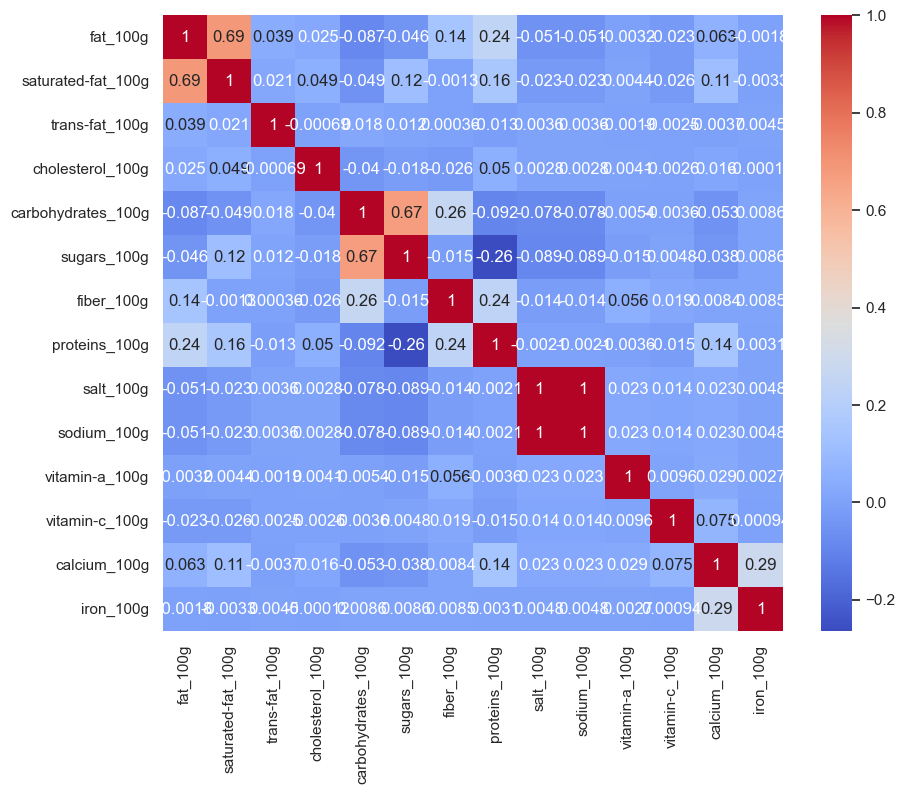

In [45]:
# Calculate the correlation matrix  
correlation_matrix = products_pre_clean[products_pre_clean_100g_columns].corr()  
  
# Create a heatmap using seaborn  
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  

In [46]:
# Todo boxplot et delete outliers
# Todo merge sodium & salt
# products_pre_clean_100g

In [47]:
products_100g = products_pre_clean[products_pre_clean_100g_columns]
products_100g.shape

(319895, 14)

In [48]:
products_100g_sampled = products_100g.sample(20000, replace=False)

In [49]:
test_full = products_100g_sampled.dropna()
test_full

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
12119,0.40,0.00,0.0,0.000,16.00,1.60,5.6,5.60,0.81280,0.320,0.000000,0.0010,0.032,0.00144
111749,6.67,0.00,0.0,0.000,33.33,26.67,6.7,53.33,4.06400,1.600,0.000000,0.0080,0.000,0.00720
118000,17.86,8.93,0.0,0.000,53.57,3.57,7.1,17.86,1.63322,0.643,0.000000,0.0000,0.071,0.00707
32265,0.00,0.00,0.0,0.003,5.33,4.00,0.0,8.00,0.10160,0.040,0.000000,0.0000,0.100,0.00000
108356,4.42,2.65,0.0,0.022,2.65,2.65,0.0,12.39,1.12268,0.442,0.000053,0.0011,0.071,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47669,0.00,0.00,0.0,0.000,92.31,71.79,0.0,0.00,0.45466,0.179,0.000000,0.0000,0.000,0.00000
104971,35.71,17.86,0.0,0.018,53.57,46.43,3.6,10.71,0.40894,0.161,0.000000,0.0000,0.143,0.00129
169956,0.00,0.00,0.0,0.112,0.00,0.00,0.0,17.65,0.74676,0.294,0.000000,0.0000,0.118,0.00000
145481,8.33,5.00,0.0,0.183,80.00,73.33,3.3,6.67,0.25400,0.100,0.000000,0.0000,0.067,0.00120


In [51]:
import random

test_with_nans = test_full.copy()
nan_percentage = 0.3
num_nan_values = int(len(test_full) * len(test_full.columns) * nan_percentage)
nan_indices = [(random.randint(0, len(test_full) - 1), random.choice(test_full.columns)) for _ in range(num_nan_values)]

for row_idx, col_idx in nan_indices:
    test_with_nans.at[row_idx, col_idx] = np.nan

test_with_nans

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
12119,0.40,0.00,0.0,0.000,16.00,1.60,5.6,5.60,0.81280,0.320,0.000000,0.0010,0.032,0.00144
111749,6.67,0.00,0.0,0.000,33.33,26.67,6.7,53.33,4.06400,1.600,0.000000,0.0080,0.000,0.00720
118000,17.86,8.93,0.0,0.000,53.57,3.57,7.1,17.86,1.63322,0.643,0.000000,0.0000,0.071,0.00707
32265,0.00,0.00,0.0,0.003,5.33,4.00,0.0,8.00,0.10160,0.040,0.000000,0.0000,0.100,0.00000
108356,4.42,2.65,0.0,0.022,2.65,2.65,0.0,12.39,1.12268,0.442,0.000053,0.0011,0.071,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Create an instance of KNNImputer with desired parameters
n_neighbors_list = list(range(1, 20, 5)) 

def rmse(random_value, true_value):
    return math.sqrt((sum((random_value - true_value)**2)) / len(random_value))

res = []
for n in n_neighbors_list:
    knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed  
      
    # Impute missing values in the dataset
    imputed_data = knn_imputer.fit_transform(test_with_nans)  
      
    # Convert the imputed_data array back into a DataFrame  
    imputed_df = pd.DataFrame(imputed_data, columns=test_with_nans.columns)
    res.append(rmse(imputed_df.values, test_full))

# faire un graph avec x axis = number of neighbors et y = rmse
# chosiir le meilleur n
# apply one last time on full dataset with best neighbors

# from sklearn.metrics import accuracy_score  
# accuracy = accuracy_score(y_test.values, imputed_test[y_test].values)
# plutot faire un RSME (absolute difference a - b et j'applique RSME)

ValueError: Unable to coerce to DataFrame, shape must be (7920, 14): given (15409, 14)

In [ ]:
imputed_df.isna().mean()

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

test2 = products_pre_clean.filter(like='_100g')
regression = test2.copy()

# Todo > test with and without and see score.
regression = regression.fillna(0)

X = regression.drop(columns=['nutrition-score-fr_100g'])
y = regression['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
reg_score = reg.score(X_test, y_test)
reg_score

0.5918239969830688

In [54]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split



regression = test2.copy()
regression['nutrition-score-fr_100g'] = test2['nutrition-score-fr_100g']

regression = regression.fillna(0)

X = regression.drop(columns=['nutrition-score-fr_100g'])
y = regression['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = linear_model.Lasso(alpha=0.001) # Connu pour enlver l'overfitting, en general il performe mieux qu'une regression linear.
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

# print(list(clf.predict(X_test)))
# print(list(y_test))

0.5918136506104466


In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regression = test2.copy()
regression['nutrition-score-fr_100g'] = test2['nutrition-score-fr_100g']

regression = regression.fillna(0)

X = regression.drop(columns=['nutrition-score-fr_100g'])
y = regression['nutrition-score-fr_100g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regr = RandomForestRegressor(n_estimators=50,max_depth=5, random_state=0)
# You need to test different parameters

regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

# print(list(regr.predict(X_test)))
# print(list(y_test))

# class sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)[source]

0.8165593832462124


In [56]:
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

NameError: name 'mean_squared_error' is not defined

In [ ]:
regr.feature_importances_
# The bigger the best

In [ ]:
X_test.columns

In [ ]:
# Bonus
from sklearn.ensemble import RandomForestRegressor

#for each feature:
# Split the dataset into two parts: one with missing values in the 'Target' column and one without
df_missing = test2[test2['sugars_100g'].isnull()]
df_complete = test2.dropna(subset=['sugars_100g'])

# Split the complete dataset into features and target
X_complete = df_complete.drop(['sugars_100g'], axis=1)
y_complete = df_complete['sugars_100g']

# Split the dataset with missing values into features
X_missing = df_missing.drop(['sugars_100g'], axis=1)

imputer = SimpleImputer(strategy='constant', fill_value=0)
X_complete = imputer.fit_transform(X_complete)
X_missing = imputer.transform(X_missing)

# Train a Random Forest Regressor model to predict missing values in the 'Target' column
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_complete, y_complete)

# Predict missing values in the 'Target' column
missing_values_predicted = rf_model.predict(X_missing)

# Fill in the missing values in the original DataFrame
my_df = test2.copy()
my_df.loc[my_df['sugars_100g'].isnull(), 'sugars_100g'] = missing_values_predicted

### PCA

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

In [ ]:
# Overfitting = trop entrainé sur le test dataset
pca = test2.copy()
pca['nutrition-score-fr_100g'] = test2['nutrition-score-fr_100g']
pca = regression.fillna(0)
target = 'nutrition-score-fr_100g'
X = pca.drop(target, axis=1)
y = pca[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_scaled = scale(X_train) # Scale = x - average de x / std(x) (normalise les features)
# Todo comprendre que tu peux normalisé des données non normalisé à la baset
X_test_scaled = scale(X_test)

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

# Lasso Regression (should remove overfitting)
lasso_reg = LassoCV().fit(X_train_scaled, y_train)
lasso_score_train = -1 * cross_val_score(lasso_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test_scaled), squared=False)

# Ridge Regression  (should remove overfitting)
ridge_reg = RidgeCV().fit(X_train_scaled, y_train)
ridge_score_train = -1 * cross_val_score(ridge_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test_scaled), squared=False)

In [ ]:
print(lr_score_test, lasso_score_test, ridge_score_test)
# If lasso & ridge gave better score, it means that linear regression is overfitted
# Score le plus bas possible.

In [ ]:
pca_model = PCA() # Without n_components parameters, it computes the features importance for every features in order.
X_train_pc = pca_model.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca_model.components_.T).loc[:4,:]

In [ ]:
pca_model.explained_variance_ratio_

In [ ]:
lin_reg = LinearRegression()

# Create empty list to store RMSE for each iteration
rmse_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg,
    X_train_pc[:,:i], # Use first k principal components
    y_train,
    cv=cv,
    scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)
    
# Visual analysis - plot RMSE vs count of principal components used
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('PCA')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');
# Tofo do it with the 200k lines

In [ ]:
best_pc_num = 12

# Train model with first 9 principal components
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get cross-validation RMSE (train set)
pcr_score_train = -1 * cross_val_score(lin_reg_pc,
X_train_pc[:,:best_pc_num],
y_train,
cv=cv,
scoring='neg_root_mean_squared_error').mean()

# Train model on training set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

# Get first 9 principal components of test set
X_test_pc = pca_model.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

In [ ]:
pcr_score_test

In [ ]:
scores = pd.DataFrame(columns=['RMSE_Train', 'RMSE_Test'])

In [ ]:
scores.loc['Linear Regression', :] = [lr_score_train, lr_score_test]
scores.loc['Lasso Regression', :] = [lasso_score_train, lasso_score_test]
scores.loc['Ridge Regression', :] = [ridge_score_train, ridge_score_test]
scores.loc['PCA (12 components)', :] = [pcr_score_train, pcr_score_test]
scores